In [2]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from helpers.plot_helpers import *
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
def upwind(u, dx=None, dt=None):
    '''
    The flux to be approximated is F(u) = u^2/2
    The sign of jacobian, i.e. dF(u)/du, defines the
    direction of backward path of the characteristic (https://folk.ntnu.no/leifh/teaching/tkt4140/._main075.html) 
    dF(u)/du = u.
    So, if u_{i+1/2} > 0, we approximate flux as 
    (F(u))_{i+1/2} = F(u_i) otherwise
    (F(u))_{i+1/2} = F(u_{i+1})
    Periodic boundary condition are assumed
    
    The resulting flux is returned on the staggered grid on the right
    face of he computational cell (i+1/2)
    '''
    # velocity in the RIGHT face of the computation cell (u_{i+1/2}=(u_i+u_{i+1})/2)
    # np.roll automatically applies periodic B.C.
    ur = (np.roll(u,-1) + u) * 0.5 
    
    # Create a mask of points with positive velocities, and 
    # consequently the upstream values are on the left
    upstream_left = ur > 0
    
    # Flux is in points i+1/2
    flux = u * 0
    # (F(u))_{i+1/2} = F(u_i) of u_{i+1/2} > 0
    # otherwise (F(u))_{i+1/2} = F(u_{i+1})
    flux = np.where(upstream_left, 0.5 * u**2, 0.5 * np.roll(u,-1)**2)
    return flux

In [3]:
def CD2_interpolation_first(u, dx=None, dt=None):
    '''
    Central-difference scheme of order 2 for F(u)=u**2/2,
    where interpolation is applied first:
    (F(u))_{i+1/2} = ((u_i+u_{i+1})/2)**2 / 2
    '''
    # velocity in the RIGHT face of the computation cell (u_{i+1/2}=(u_i+u_{i+1})/2)
    # np.roll automatically applies periodic B.C.
    ur = (np.roll(u,-1) + u) * 0.5 
    
    return 0.5 * ur**2

In [4]:
def CD2(u, dx=None, dt=None):
    '''
    Central-difference scheme of order 2 for F(u)=u**2/2,
    where interpolation is applied after square:
    (F(u))_{i+1/2} = (u_i**2/2 + u_{i+1}**2/2)/2
    '''
    # Flux in center of computational cell
    flux = 0.5 * u**2
    return (flux + np.roll(flux,-1)) * 0.5

In [5]:
def CD4(u, dx=None, dt=None):
    '''
    Central-difference scheme of order 4 for F(u)=u**2/2,
    Interpolation weight are given by Table 2.1 in "High Order ENO and WENO Schemes for
    Computational Fluid Dynamics" by Chi-Wang Shu
    (F(u))_{i+1/2} = 7/12 * (u_i**2/2 + u_{i+1}**2/2) - 1/12 * (u_{i-1}**2/2 + u_{i+2}**2/2)
    '''
    # Flux in center of computational cell
    flux = 0.5 * u**2
    return 7./12. * (flux + np.roll(flux,-1)) - 1./12. * (np.roll(flux,-2)+np.roll(flux,1))

In [6]:
def CD6(u, dx=None, dt=None):
    '''
    Central-difference scheme of order 6 for F(u)=u**2/2,
    Interpolation weight are given by Table 2.1 in "High Order ENO and WENO Schemes for
    Computational Fluid Dynamics" by Chi-Wang Shu
    (F(u))_{i+1/2} = 37/60 * (u_i**2/2 + u_{i+1}**2/2) - 2/15 * (u_{i-1}**2/2 + u_{i+2}**2/2) + 
    1/60 * (u_{i-2}**2/2 + u_{i+3}**2/2)
    '''
    # Flux in center of computational cell
    flux = 0.5 * u**2
    return 37./60. * (flux + np.roll(flux,-1)) - 2./15. * (np.roll(flux,-2)+np.roll(flux,1)) + \
            1./60. * (np.roll(flux,-3)+np.roll(flux,2))

In [7]:
def Lax_Friedrichs(u, dx=None, dt=None):
    '''
    Lax_Friedrichs method in flux form for F(u)=u**2/2, see
    https://en.wikipedia.org/wiki/Lax%E2%80%93Friedrichs_method#:~:text=We%20note%20that%20this%20method%20can%20be%20written%20in%20conservation%20form%3A
    
    (F(u))_{i+1/2} = 
    
    Central-difference scheme of order 2 for F(u)=u**2/2,
    where interpolation is applied after square:
    (F(u))_{i+1/2} = (u_i**2/2 + u_{i+1}**2/2)/2 - 0.5 * dx/dt * (u_{i+1}-u_{i})
    '''
    # Flux in center of computational cell
    flux = 0.5 * u**2
    return (flux + np.roll(flux,-1)) * 0.5 - 0.5 * dx/dt * (np.roll(u,-1) - u)

In [556]:
# Functions counting the number of local min/max
def nmax(u):
    return (np.logical_and(u > np.roll(u,1)+1e-15, u > np.roll(u,-1)+1e-15)).sum()

def nmin(u):
    return (np.logical_and(u < np.roll(u,1)-1e-15, u < np.roll(u,-1)-1e-15)).sum()

In [143]:
def Euler_integrator(u, Nt=1, dt=0.01, flux_function=upwind):
    '''
    Here we integrate the equation
    du/dt + dF(u)/dx = 0
    Forward Euler method and provided flux function:
    u = u - dt * ((F(u))_{i+1/2} - (F(u))_{i-1/2}) / dx
    Here we assume the domain length is 2*pi and automatically compute dx
    '''
    if Nt==0:
        return u
    
    u_ = u.copy()
    dx = float(2*np.pi / len(u))
    
    CFL = np.max(u) * dt / dx
    if (CFL>1.):
        print('CFL in initial condition: ', CFL)
    
    for nt in range(Nt):
        flux = flux_function(u_, dx, dt)
        # This formula assumes that flux is on the right 
        # face of the computational cell. Also, it assumes
        # periodic boundary condition
        u_ = u_ - dt * (flux - np.roll(flux,1)) / dx
    
    if (np.max(u_) > np.max(u)) or (np.min(u_) < np.min(u)) or (np.sum(np.isnan(u_))>0) or (nmin(u_) > nmin(u)) or (nmax(u_) > nmax(u)):
        print(f'max: {np.max(u_)}, min: {np.min(u_)}, nmax: {nmax(u_)}, nmin: {nmin(u_)}, nans: {np.sum(np.isnan(u_))}')
    return u_

In [144]:
def RK4_integrator(u, Nt=1, dt=0.01, flux_function=upwind):
    '''
    Here we implement classical RK4 method 
    https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=Now%20we%20pick%20a%20step%2Dsize%20h%20%3E%200%20and%20define%3A
    for equation 
    du/dt + dF(u)/dx = 0
    '''
    if Nt==0:
        return u
    
    u_ = u.copy()
    dx = float(2*np.pi / len(u))
    
    CFL = np.max(u) * dt / dx
    if (CFL>1.):
        print('CFL in initial condition: ', CFL)
    
    def rhs(u):
        '''
        Here we create a function transforming flux
        to the right hand side for simplicity of 
        implementation of the RK4
        '''
        flux = flux_function(u, dx, dt)
        return - (flux - np.roll(flux,1)) / dx
    
    for nt in range(Nt):
        k1 = rhs(u_)
        k2 = rhs(u_+0.5*dt*k1)
        k3 = rhs(u_+0.5*dt*k2)
        k4 = rhs(u_+dt*k3)
        u_ = u_ + dt/6. * (k1 + 2.*k2 + 2.*k3 + k4)
    
    if (np.max(u_) > np.max(u)) or (np.min(u_) < np.min(u)) or (np.sum(np.isnan(u_))>0) or (nmin(u_) > nmin(u)) or (nmax(u_) > nmax(u)):
        print(f'max: {np.max(u_)}, min: {np.min(u_)}, nmax: {nmax(u_)}, nmin: {nmin(u_)}, nans: {np.sum(np.isnan(u_))}')
    return u_

In [535]:
def Boris_Book_integrator(u, Nt=1, dt=0.01, low_order_flux=upwind, high_order_flux=CD6):
    '''
    Here we integrate the equation
    du/dt + dF(u)/dx = 0
    We apply flux limiter (flux-corrected transport, FCT) originally proposed by
    Boris Book 1973. We use Eq. (5) from Zalesak 1979
    "Fully multidimensional flux-corrected transport algorithms for fluids"
    '''
    if Nt==0:
        return u
    
    u_ = u.copy()
    dx = float(2*np.pi / len(u))
    
    CFL = np.max(u) * dt / dx
    if (CFL>1.):
        print('CFL in initial condition: ', CFL)
    
    for nt in range(Nt):
        # Note that here fluxes are multiplied by dt
        # to follow the notation of Zalesak 1979
        low_flux = dt / dx * low_order_flux(u_, dx, dt)
        high_flux = dt / dx * high_order_flux(u_, dx, dt)
        # Compute antidiffusive flux
        anti_flux = high_flux - low_flux
        
        u_td = u_ - (low_flux - np.roll(low_flux,1))
        
        # Determine the bounds for solution by analyzing the neighbouring cells
        u_max = np.maximum(np.maximum(u_td, np.roll(u_td, -1)), np.roll(u_td, +1))
        u_min = np.minimum(np.minimum(u_td, np.roll(u_td, -1)), np.roll(u_td, +1))

        
        # Limit the antidiffusive flux
        S = np.sign(anti_flux)
        
        # Minimum value of finite differences
        # min(Sign * (u_td_{i+2}-u_td_{i+1})*dx, Sign * (u_td_{i}-u_td_{i-1})*dx)
        FD = np.minimum(S * (np.roll(u_td,-2)-np.roll(u_td,-1)), S * (u_td-np.roll(u_td,+1)))
        # Minimum value between FD and abs antidiffusive flux
        minval = np.minimum(FD, np.abs(anti_flux))
        
        corrected_flux = S * np.maximum(0., minval)
        
        u_ = u_td - (corrected_flux - np.roll(corrected_flux,1))
        
        if (u_ > u_max+1e-15).sum() > 0 or (u_ < u_min-1e-15).sum() > 0:
            print('Local bounds of u_max and u_min were violated')
        
    if (np.max(u_) > np.max(u)) or (np.min(u_) < np.min(u)) or (np.sum(np.isnan(u_))>0) or (nmin(u_) > nmin(u)) or (nmax(u_) > nmax(u)):
        print(f'max: {np.max(u_)}, min: {np.min(u_)}, nmax: {nmax(u_)}, nmin: {nmin(u_)}, nans: {np.sum(np.isnan(u_))}')
       
    return u_

In [674]:
def Zalesak_integrator(u, Nt=1, dt=0.01, low_order_flux=upwind, high_order_flux=CD6, bound_downgradient=True, better_min_max=False, dt_agnostic=False, simple_R=False):
    '''
    Here we integrate the equation
    du/dt + dF(u)/dx = 0
    We apply flux limiter of Zalesak 1979 "Fully multidimensional flux-corrected transport algorithms for fluids"
    described in Section IV
    '''
    if Nt==0:
        return u
    
    u_ = u.copy()
    dx = float(2*np.pi / len(u))
    
    CFL = np.max(u) * dt / dx
    if (CFL>1.):
        print('CFL in initial condition: ', CFL)
    
    for nt in range(Nt):
        # Note that here fluxes are multiplied by dt
        # to follow the notation of Zalesak 1979
        low_flux = dt * low_order_flux(u_, dx, dt)
        high_flux = dt * high_order_flux(u_, dx, dt)
        # Compute antidiffusive flux
        anti_flux = high_flux - low_flux
        
        u_td = u_ - (low_flux - np.roll(low_flux,1)) / dx
        
        if bound_downgradient:
            # We first apply their Eq. (14) and clip spurious downgradient fluxes
            mask = np.logical_and((anti_flux * (np.roll(u_td,-1) - u_td) < 0), \
                   np.logical_or((anti_flux * (np.roll(u_td,-2) - np.roll(u_td,-1)) < 0), \
                                 (anti_flux * (u_td - np.roll(u_td,+1)) < 0)))
            anti_flux[mask] = 0.
        
        # Determine the bounds for solution by analyzing the neighbouring cells
        if better_min_max:
            ua = np.maximum(u_td, u_)
            ub = np.minimum(u_td, u_)
        else:
            ua = u_td
            ub = u_td
        u_max = np.maximum(np.maximum(ua, np.roll(ua, -1)), np.roll(ua, +1))
        u_min = np.minimum(np.minimum(ub, np.roll(ub, -1)), np.roll(ub, +1))
        
        # Determine maximum admittable flux into the grid box ("plus") and out of 
        # the grid box ("minus")
        Q_plus = (u_max - u_td) * dx
        Q_minus = (u_td - u_min) * dx
        
        # Determine sum of fluxes into and out the grid box:
        P_plus = np.maximum(0, np.roll(anti_flux,1)) - np.minimum(0, anti_flux)
        P_minus = np.maximum(0, anti_flux) - np.minimum(0, np.roll(anti_flux,1))
        
        # Determine ratios of admissible fluxes
        if dt_agnostic:
            if simple_R:
                # Here we introduce limiter for local minimum/maximum
                # independent on wheather fluxes should be limited or not
                R_plus = np.where(Q_plus < 1e-15, 0., 1.)
                R_minus = np.where(Q_minus < 1e-15, 0., 1.)
            else:
                # Here we completely multiply by zero fluxes if there is 
                # local extremum
                R_plus = np.where(np.logical_and(P_plus > 1e-15, Q_plus < 1e-15), 0., 1.)
                R_minus = np.where(np.logical_and(P_minus > 1e-15, Q_minus < 1e-15), 0., 1.)
        else:
            # This difference in what to set 0 or 1 does not actually matter for most solutions
            if simple_R:
                R_plus = np.where(P_plus>0, np.minimum(1., Q_plus/P_plus), 1.)
                R_minus = np.where(P_minus>0, np.minimum(1., Q_minus/P_minus), 1.)
            else:
                R_plus = np.where(P_plus>0, np.minimum(1., Q_plus/P_plus), 0.)
                R_minus = np.where(P_minus>0, np.minimum(1., Q_minus/P_minus), 0.)
        
        # Correction factor, between 0 and 1
        C = np.where(anti_flux >=0, np.minimum(np.roll(R_plus,-1),R_minus), np.minimum(R_plus, np.roll(R_minus,-1)))
        
        corrected_flux = anti_flux * C
        
        u_ = u_td - (corrected_flux - np.roll(corrected_flux,1)) / dx
        if (u_ > u_max+1e-15).sum() > 0 or (u_ < u_min-1e-15).sum() > 0:
            print('Local bounds of u_max and u_min were violated')
        
    if (np.max(u_) > np.max(u)) or (np.min(u_) < np.min(u)) or (np.sum(np.isnan(u_))>0) or (nmin(u_) > nmin(u)) or (nmax(u_) > nmax(u)):
        print(f'max: {np.max(u_)}, min: {np.min(u_)}, nmax: {nmax(u_)}, nmin: {nmin(u_)}, nans: {np.sum(np.isnan(u_))}')
       
    return u_

Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
max: 0.2861548980329896, min: -0.28615489803299227, nmax: 7, nmin: 7, nans: 0
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Lo

Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min we

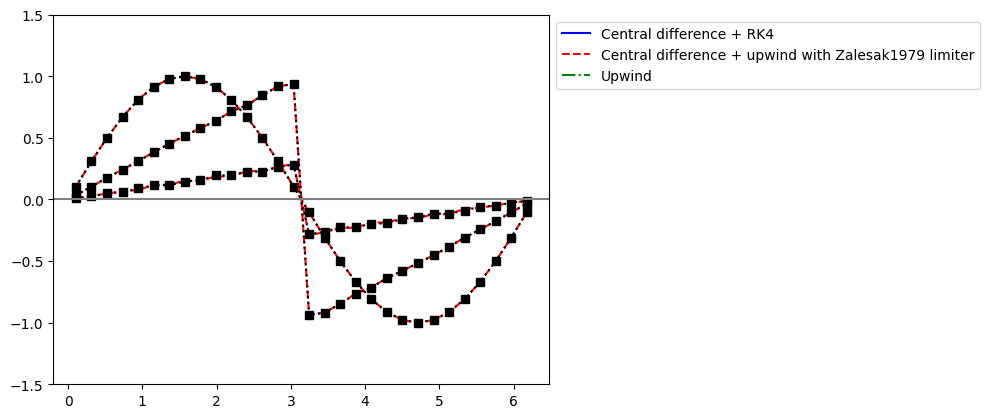

In [676]:
def init(N=30):
    dx = 2*np.pi / N
    x = dx/2 + (np.arange(N)) * dx
    return np.sin(x), x
    #return np.exp(-2 * (x-np.pi)**2), x
u0, x = init()

for Nt in [0, 200, 1000]:
    #plt.plot(x,RK4_integrator(u0, Nt, dt=0.01, flux_function=CD2), color='b')
    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2), color='r', ls='--')
    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2, dt_agnostic=True), color='k', ls=':')
    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2, dt_agnostic=True, simple_R=True), color='k', ls='', marker='s')
#    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2, bound_downgradient=False), color='tab:orange', ls=':')
#    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2, better_min_max=True), color='tab:orange', ls=':')
    #plt.plot(x,Euler_integrator(u0, Nt, dt=0.01, flux_function=upwind), color='g', ls='-.')
plt.ylim([-1.5,1.5])
plt.axhline(y=0, color='gray')
plt.plot(np.nan, np.nan, color='b', label='Central difference + RK4')
plt.plot(np.nan, np.nan, color='r', ls='--', label='Central difference + upwind with Zalesak1979 limiter')
plt.plot(np.nan, np.nan, color='g', ls='-.', label='Upwind')
plt.legend(bbox_to_anchor=(1,1))

max: 0.6393787797559866, min: 1.1379998578468668e-07, nmax: 3, nmin: 3, nans: 0
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated
Local bounds of u_max and u_min were violated


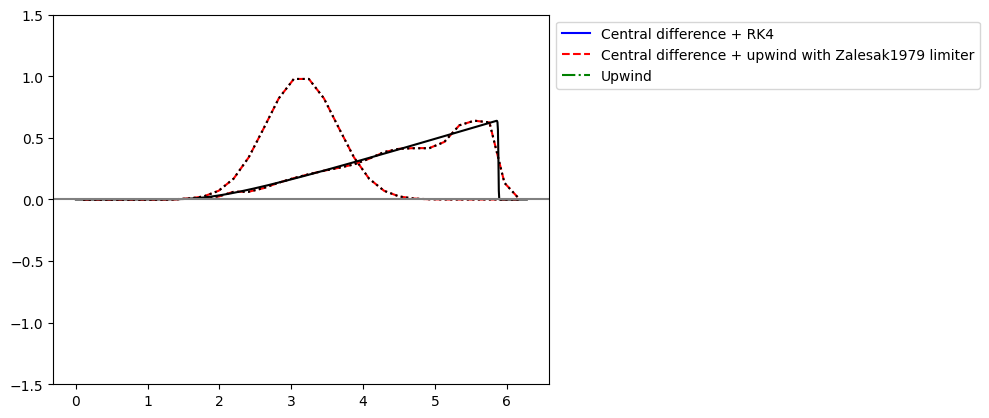

In [673]:
def init(N=30):
    dx = 2*np.pi / N
    x = dx/2 + (np.arange(N)) * dx
    #return np.sin(x), x
    return np.exp(-2 * (x-np.pi)**2), x
u0, x = init()

for Nt in [0, 500]:
    #plt.plot(x,RK4_integrator(u0, Nt, dt=0.01, flux_function=CD2), color='b')
    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2), color='r', ls='--')
    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2, dt_agnostic=True), color='k', ls=':')
#    plt.plot(x,Zalesak_integrator(u0, Nt, dt=0.01, low_order_flux=upwind, high_order_flux=CD2, bound_downgradient=False), color='tab:orange', ls=':')
    #plt.plot(x,Euler_integrator(u0, Nt, dt=0.01, flux_function=upwind), color='g', ls='-.')
plt.ylim([-1.5,1.5])

def init(N=1000):
    dx = 2*np.pi / N
    x = dx/2 + (np.arange(N)) * dx
    #return np.sin(x), x
    return np.exp(-2 * (x-np.pi)**2), x
u0, x = init()
plt.plot(x,Euler_integrator(u0, 5000, dt=0.001, flux_function=upwind), color='k')

plt.axhline(y=0, color='gray')
plt.plot(np.nan, np.nan, color='b', label='Central difference + RK4')
plt.plot(np.nan, np.nan, color='r', ls='--', label='Central difference + upwind with Zalesak1979 limiter')
plt.plot(np.nan, np.nan, color='g', ls='-.', label='Upwind')
plt.legend(bbox_to_anchor=(1,1))

In [658]:
def init(N=1000):
    dx = 2*np.pi / N
    x = dx/2 + (np.arange(N)) * dx
    return np.sin(x), x
    #return np.exp(-2 * (x-np.pi)**2), x

np.abs(Zalesak_integrator(u0, 500, dt=0.01, low_order_flux=upwind, high_order_flux=CD6, simple_R=True) - \
Zalesak_integrator(u0, 500, dt=0.01, low_order_flux=upwind, high_order_flux=CD6)).max()

max: 0.5127182921031651, min: -0.5127182921031691, nmax: 7, nmin: 7, nans: 0
max: 0.5127182921031651, min: -0.5127182921031691, nmax: 7, nmin: 7, nans: 0


0.0

In [632]:
N = 100; NN = 1000
Nt = 5000; NNt = int(Nt * NN / N)
# Compute high-resolution solution
u0_true, x_true = init(N=NN)
utrue = Euler_integrator(u0_true, NNt, dt=0.005, flux_function=upwind)

u0, x = init(N=N)
utrue_coarse = np.interp(x, x_true, utrue)

u = Boris_Book_integrator(u0, Nt, dt=0.05, low_order_flux=upwind, high_order_flux=CD6)
rmse = ((u - utrue_coarse)**2).mean()
print('RMSE for FCT upwind+CD6 = ', rmse)

u = Boris_Book_integrator(u0, Nt, dt=0.05, low_order_flux=upwind, high_order_flux=CD4)
rmse = ((u - utrue_coarse)**2).mean()
print('RMSE for FCT upwind+CD4 = ', rmse)

u = Boris_Book_integrator(u0, Nt, dt=0.05, low_order_flux=upwind, high_order_flux=CD2)
rmse = ((u - utrue_coarse)**2).mean()
print('RMSE for FCT upwind+CD2 = ', rmse)

u = Zalesak_integrator(u0, Nt, dt=0.05, low_order_flux=upwind, high_order_flux=CD2)
rmse = ((u - utrue_coarse)**2).mean()
print('RMSE for FCT Zalesak upwind+CD2 = ', rmse)

u = RK4_integrator(u0, Nt, dt=0.05, flux_function=CD2)
rmse = ((u - utrue_coarse)**2).mean()
print('RMSE for RK4+CD2 = ', rmse)

u = Euler_integrator(u0, Nt, dt=0.05, flux_function=upwind)
rmse = ((u - utrue_coarse)**2).mean()
print('RMSE for upwind = ', rmse)

# u = Euler_integrator(u0, Nt, dt=0.05, flux_function=Lax_Friedrichs)
# rmse = ((u - utrue_coarse)**2).mean()
# print('RMSE for Lax-Friedrichs = ', rmse)

# u = Boris_Book_integrator(u0, Nt, dt=0.05, low_order_flux=Lax_Friedrichs, high_order_flux=CD6)
# rmse = ((u - utrue_coarse)**2).mean()
# print('RMSE for FCT Lax_Friedrichs+CD6 = ', rmse)


max: 0.012571988394763532, min: -0.012571988394724497, nmax: 1, nmin: 1, nans: 0
max: 0.012691891758945417, min: -0.01269189175894167, nmax: 29, nmin: 29, nans: 0
RMSE for FCT upwind+CD6 =  9.877555999028472e-06
max: 0.012794398293095909, min: -0.012794398293091045, nmax: 31, nmin: 31, nans: 0
RMSE for FCT upwind+CD4 =  3.170464608152891e-05
max: 0.0123676335343548, min: -0.012367633534356352, nmax: 28, nmin: 28, nans: 0
RMSE for FCT upwind+CD2 =  9.039376560823306e-07
max: 0.01236763353435621, min: -0.012367633534349215, nmax: 28, nmin: 28, nans: 0
RMSE for FCT Zalesak upwind+CD2 =  9.039376560823122e-07
max: nan, min: nan, nmax: 0, nmin: 0, nans: 100
RMSE for RK4+CD2 =  nan
RMSE for upwind =  0.0006194066807082465


# FCT limiter in MOM6 applied to ANN fluxes

In [51]:
mom = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-FCT/mom__0011_009.nc')
prog = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-FCT/prog__0011_009.nc')

In [79]:
#prog.RV.hvplot(x='xq', y='yq', width=500, height=500, clim=(-4e-5, 4e-5), cmap='bwr') + \
(mom.Txy).hvplot(x='xq', y='yq', width=500, height=500, clim=(-0.04,0.04), cmap='bwr')+\
(mom.Txy-mom.Txy_smag).hvplot(x='xq', y='yq', width=500, height=500, clim=(-0.04,0.04), cmap='bwr')

:Layout
   .DynamicMap.I  :DynamicMap   [Time,zl]
      :Image   [xq,yq]   (Txy)
   .DynamicMap.II :DynamicMap   [Time,zl]
      :Image   [xq,yq]   (value)

In [53]:
mom.Esource_smag.hvplot(x='xh', y='yh', width=400, height=500, cmap='bwr', clim=(-5e-5,5e-5)) + \
mom.Esource_ZB.hvplot(x='xh', y='yh', width=400, height=500, cmap='bwr', clim=(-5e-5,5e-5))

:Layout
   .DynamicMap.I  :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (Esource_smag)
   .DynamicMap.II :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (Esource_ZB)

## Check if it helps to preserve monotonicity

In [54]:
mom = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-FCT/mom__0011_009.nc')
prog = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-FCT/prog__0011_009.nc')

In [887]:
# mom = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-SGS-KE-div-upwind-time-collocated/output/mom__0004_016.nc')
# prog = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-SGS-KE-div-upwind-time-collocated/output/prog__0004_016.nc')

In [55]:
FCT = (mom.FCT_Txx * mom.FCT_Tyy)[-1][0].values
u = mom.u_ZB[-1][0].values
v = mom.v_ZB[-1][0].values
dudt = mom.ZB2020u[-1][0].values
dvdt = mom.ZB2020v[-1][0].values
unew = u + dudt # Here time step is 1
vnew = v + dvdt # Here time step is 1
unew = unew[1:-1,1:-1]
vnew = vnew[1:-1,1:-1]

In [56]:
def umax(u):
    ulr = np.maximum(u[2:,1:-1], u[:-2,1:-1])
    uud = np.maximum(u[1:-1,2:], u[1:-1,:-2])
    uvert = np.maximum(uud, u[1:-1,1:-1])
    return np.maximum(uvert, ulr)

In [57]:
def umin(u):
    ulr = np.minimum(u[2:,1:-1], u[:-2,1:-1])
    uud = np.minimum(u[1:-1,2:], u[1:-1,:-2])
    uvert = np.minimum(uud, u[1:-1,1:-1])
    return np.minimum(uvert, ulr)

In [58]:
show = lambda x: plt.imshow(np.flipud(x), cmap='bwr', clim=(-1,1))

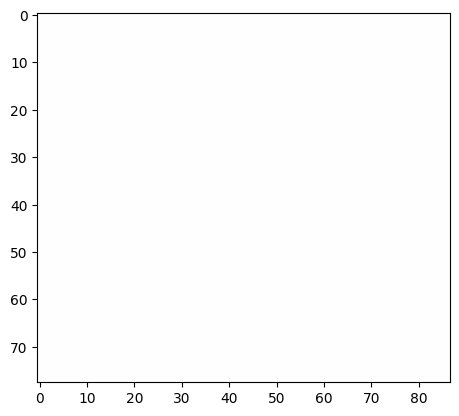

In [59]:
show(unew<umin(u))

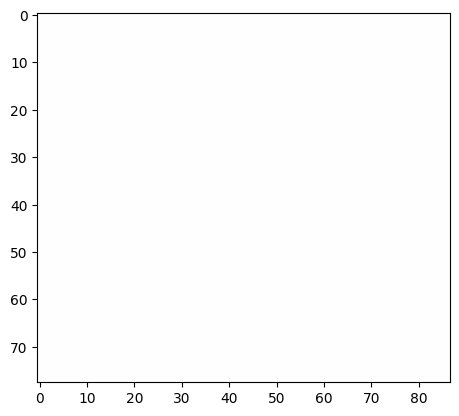

In [60]:
show(unew>umax(u))

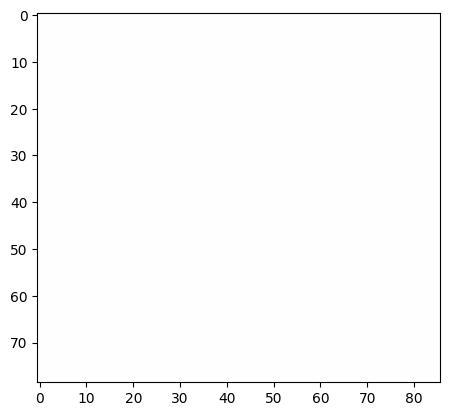

In [61]:
show(vnew>umax(v))

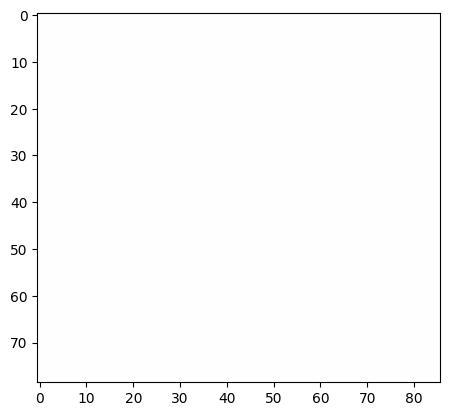

In [62]:
show(vnew<umin(v))